**Setting up Kaggle and downloading the Dataset using API**

In [6]:
!pip install kaggle

In [7]:
# Configuring path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Kaggle API
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

 99% 537M/545M [00:05<00:00, 95.5MB/s]
100% 545M/545M [00:05<00:00, 100MB/s] 


**Importing Libraries**

In [62]:
from zipfile import ZipFile
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from joblib import dump

**Data Preprocessing**

In [10]:
dataset = '/content/cat-dog-images-for-classification.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The Dataset is extracted')

The Dataset is extracted


In [11]:
path, dirs, files = next(os.walk('/content/cat_dog'))
files_count = len(files)
print('Number of Images:', files_count)

Number of Images: 25000


In [12]:
files = os.listdir('/content/cat_dog')
cat = 0
dog = 0
for images in files:
  img = images.split('.')[0]
  if (img == 'cat'):
    cat += 1
  else:
    dog += 1
print('Number of Dog images:', dog)
print('Number of Cat images:', cat)

Number of Dog images: 12500
Number of Cat images: 12500


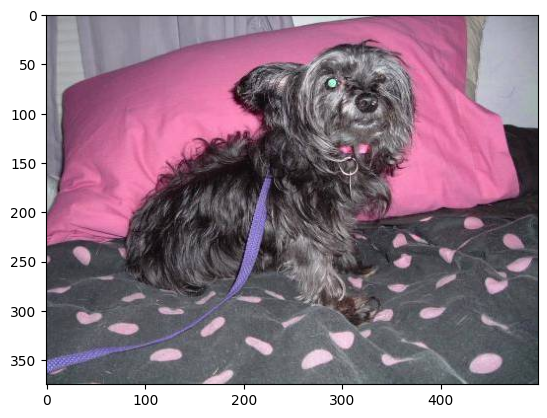

In [13]:
img = mpimg.imread('/content/cat_dog/dog.0.jpg')
plt.imshow(img)

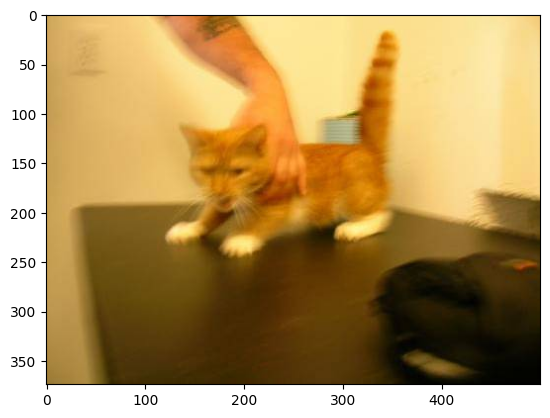

In [14]:
img = mpimg.imread('/content/cat_dog/cat.0.jpg')
plt.imshow(img)

**Resizing Images**

In [15]:
os.mkdir('/content/resized-images')

In [16]:
original_folder = '/content/cat_dog/'
resized_folder = '/content/resized-images/'

files = os.listdir('/content/cat_dog')

for i in range (2000):
  filename = os.listdir(original_folder)[i]
  imagepath = original_folder + filename

  img = Image.open(imagepath)
  img = img.resize((224, 224))
  img = img.convert('RGB')

  newImagepath = resized_folder + filename
  img.save(newImagepath)

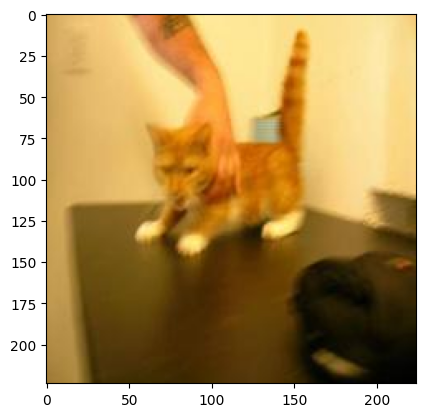

In [17]:
img = mpimg.imread('/content/resized-images/cat.0.jpg')
plt.imshow(img)

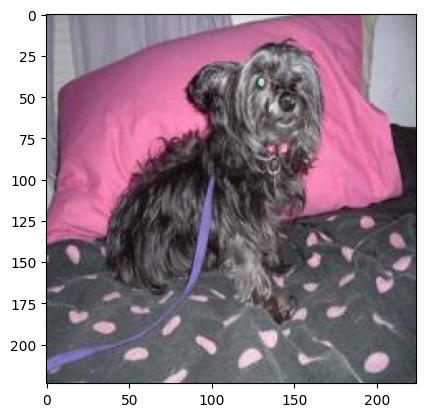

In [18]:
img = mpimg.imread('/content/resized-images/dog.0.jpg')
plt.imshow(img)

In [19]:
files = os.listdir('/content/resized-images')[:2000]
label = []
for images in files:
  img = images.split('.')[0]
  if (img == 'cat'):
    label.append(0)
  else:
    label.append(1)

In [20]:
labels, count = np.unique(label, return_counts=True)
print(labels)
print(count)

[0 1]
[ 999 1001]


**Visualizing count of images**

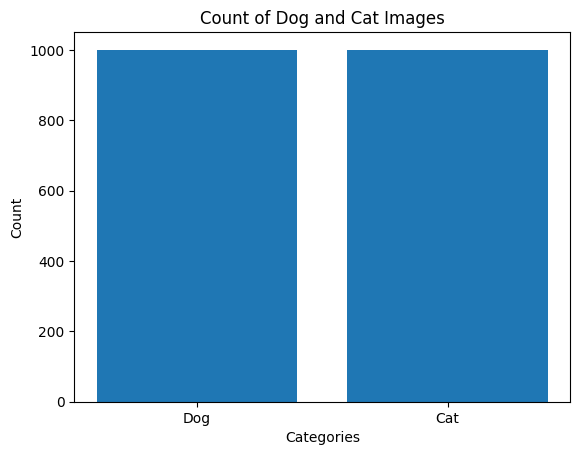

In [21]:
label_names = ['Dog', 'Cat']

plt.bar(labels, count, tick_label=label_names)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Count of Dog and Cat Images')
plt.show()

**Converting images into Numpy array**

In [22]:
img_dir = '/content/resized-images'[:2000]
img_extn = ['jpg']

files = []

[files.extend(glob.glob(img_dir + '/*.' + ext)) for ext in img_extn]
dog_cat_img = np.asarray([cv2.imread(file) for file in files])

In [23]:
print(dog_cat_img)

[[[[ 22  21  23]
   [ 22  21  23]
   [ 22  21  23]
   ...
   [ 69  78  88]
   [ 67  76  86]
   [ 58  67  77]]

  [[ 21  20  22]
   [ 21  20  22]
   [ 21  20  22]
   ...
   [ 68  77  87]
   [ 67  76  86]
   [ 60  69  79]]

  [[ 20  19  21]
   [ 20  19  21]
   [ 19  18  20]
   ...
   [ 63  72  82]
   [ 62  71  81]
   [ 59  68  78]]

  ...

  [[142 153 157]
   [144 155 159]
   [145 156 160]
   ...
   [128 139 147]
   [134 146 152]
   [129 141 147]]

  [[134 145 149]
   [141 152 156]
   [145 156 160]
   ...
   [145 156 164]
   [154 166 172]
   [151 163 169]]

  [[131 142 146]
   [140 151 155]
   [142 153 157]
   ...
   [150 161 169]
   [160 172 178]
   [157 169 175]]]


 [[[ 95 117 158]
   [ 88 110 151]
   [ 94 116 157]
   ...
   [170 191 219]
   [171 192 220]
   [174 195 223]]

  [[ 86 108 149]
   [ 89 111 152]
   [ 97 119 160]
   ...
   [166 187 215]
   [167 188 216]
   [170 191 219]]

  [[ 85 107 148]
   [ 96 118 159]
   [105 128 166]
   ...
   [163 184 212]
   [163 184 212]
   [164 185

In [24]:
dog_cat_img.shape

(2000, 224, 224, 3)

**Separating Data and Label**

In [25]:
X = dog_cat_img
Y = np.asarray(label)

**Splitting the Training and Testing Data**

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [27]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (1600, 224, 224, 3)
Y_train shape: (1600,)
X_test shape: (400, 224, 224, 3)
Y_test shape: (400,)


**Scaling the Data**

In [28]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

**Importing the pretrained MobileNetV2 model**

In [30]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224, 224, 3), trainable=False)

**Model Architecture**

In [48]:
model = Sequential()
model.add(pretrained_model)
model.add(Dense(2, activation='softmax'))

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


**Training the Model**

In [51]:
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 7s 101ms/step - loss: 0.2899 - accuracy: 0.8766 - val_loss: 0.1081 - val_accuracy: 0.9625
Epoch 2/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0815 - accuracy: 0.9711 - val_loss: 0.0718 - val_accuracy: 0.9688
Epoch 3/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.0573 - val_accuracy: 0.9812
Epoch 4/10
40/40 [==============================] - 2s 55ms/step - loss: 0.0497 - accuracy: 0.9867 - val_loss: 0.0537 - val_accuracy: 0.9844
Epoch 5/10
40/40 [==============================] - 3s 63ms/step - loss: 0.0367 - accuracy: 0.9922 - val_loss: 0.0484 - val_accuracy: 0.9875
Epoch 6/10
40/40 [==============================] - 2s 59ms/step - loss: 0.0312 - accuracy: 0.9937 - val_loss: 0.0489 - val_accuracy: 0.9875
Epoch 7/10
40/40 [==============================] - 2s 57ms/step - loss: 0.0266 - accuracy: 0.9961 - val_loss: 0.0486 - val_accuracy: 0.9812
Epoch 8/10
4

**Visualizing the Model Loss and Accuracy**

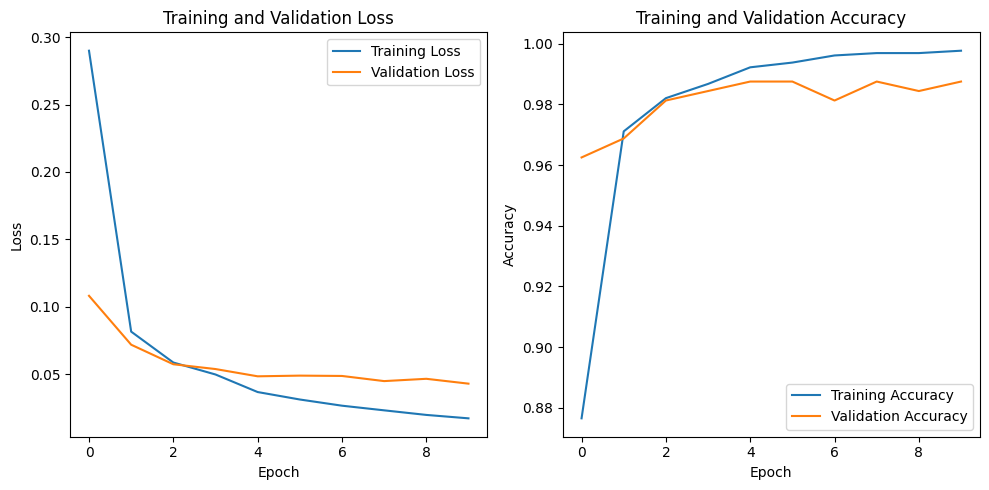

In [52]:
# Extracting training/validation loss and accuracy from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Creating a figure
plt.figure(figsize=(10, 5))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

**Score and Accuracy of the Model**

In [53]:
score, acc = model.evaluate(X_test_scaled, Y_test)
print('Test Loss:', score)
print('Test Accuracy:', acc)

13/13 [==============================] - 2s 118ms/step - loss: 0.0438 - accuracy: 0.9825
Test Loss: 0.04380735382437706
Test Accuracy: 0.9825000166893005


**Prediction on Test data**

In [56]:
y_pred = model.predict(X_test_scaled)

13/13 [==============================] - 1s 45ms/step


In [58]:
y_pred = np.argmax(y_pred, axis=1)

**Classification Report**

In [59]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.98      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



**Confusion Matrix**

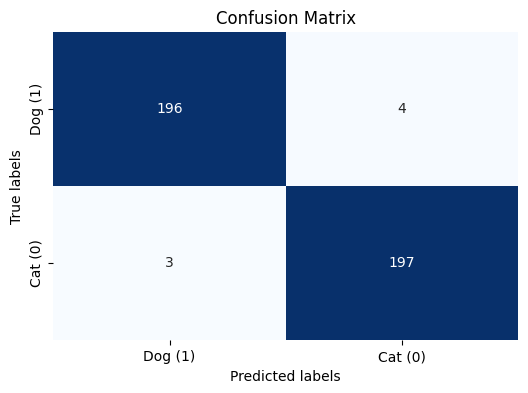

In [67]:
label_names = ['Dog (1)', 'Cat (0)']

cm = confusion_matrix(Y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Saving the Model**

In [68]:
dump(model, 'model.joblib')

['model.joblib']